In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18, z_at_value
from scipy.ndimage.filters import gaussian_filter
import astropy.units as u
import hankl
%matplotlib inline

# Calculate $C_l^{\Delta \phi}(k_1,k_2)$

Text(0.5, 1.0, 'Fiducial')

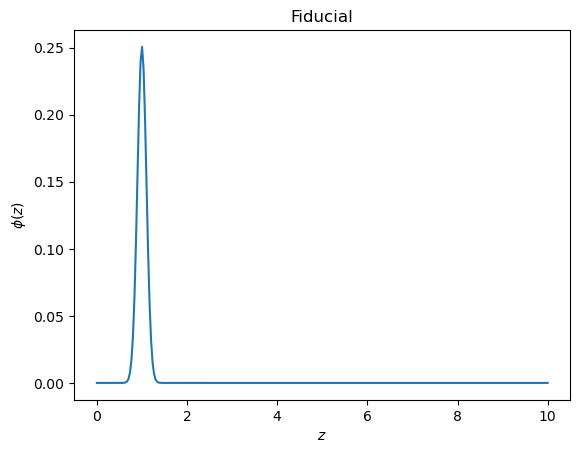

In [320]:
sigma = 0.1 # Standard deviation of the fiducial dndz
sigma_zshift = 0.1 # Standard deviation of the z_shift
z_mean = 1 # Central redshift of the nominal dndz

# Plot the fiducial dndz
zs = np.linspace(0,10,300)
dndz_fid = sigma*np.sqrt(2*np.pi)*np.exp(-(zs - z_mean)**2 /(2*sigma**2))
plt.plot(zs, dndz_fid)
plt.ylabel(r'$\phi(z)$')
plt.xlabel(r'$z$')
plt.title('Fiducial')

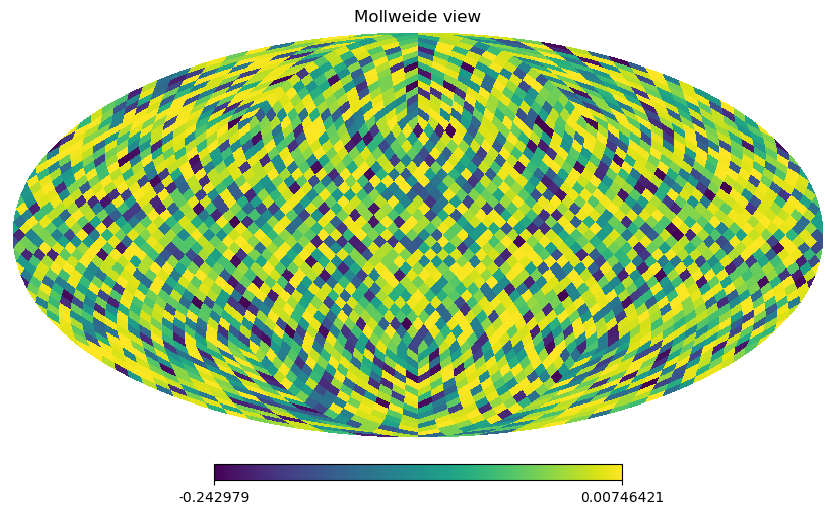

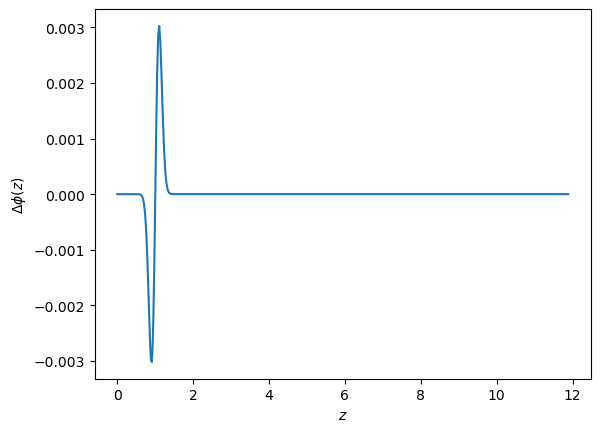

In [381]:
# Suppose the central value of the dndz changes across different healpixels
nside = 16 # Nside that sets the size of pixels over which dn/dz is constant
npix = hp.nside2npix(nside)

# Initialize samples in r to be used in FFTLog calculation of the Hankel transforms
n_samples_of_r = 2**10 # Choose a power of 2
log_rmin = -4 # Choose integers here
log_rmax = 4 # Choose integers here
r_array = np.logspace(log_rmin,log_rmax,n_samples_of_r) 
# Get the redshift corresponding to these values of r in the Planck18 cosmology
z_array = np.zeros((npix, n_samples_of_r))
for i, r in enumerate(r_array):
    z_array[:, i] = z_at_value(Planck18.comoving_distance, r* u.Mpc)  

# Draw random values in each pixel for the shift of the central redshift of the dndz
shifts_array = np.random.normal(loc=0, scale=sigma_zshift, size=npix)

# Calculate the perturbation to the dndz in each pixel and each r slice
theta_maps = sigma*np.sqrt(2*np.pi)*(np.exp(-(z_array - z_mean - shifts_array[..., np.newaxis])**2 /(2*sigma**2)) - np.exp(-(z_array - z_mean )**2 /(2*sigma**2)))
# Plot a map of the r slice where we expect significant fluctuations
z_mean_idx = np.where(r_array>Planck18.comoving_distance(z_mean).value)[0][0]
hp.mollview(theta_maps[:,z_mean_idx])
plt.show()

# Plot the Delta phi (z) at a random pixel
pix_idx = np.random.randint(0, npix)
plt.plot(z_array[pix_idx,:], theta_maps[pix_idx,:])
plt.ylabel(r'$\Delta \phi(z)$')
plt.xlabel(r'$z$')
plt.show()

In [382]:
# Let us up-sample the maps
nside_out = 128 # If running on a laptop, don't go above nside_out=128 (nside_out = 256 already requires 20Gb of memory)

theta_maps_upsampled = np.zeros((hp.nside2npix(nside_out), n_samples_of_r))
for i in range(len(r_array)):
    theta_maps_upsampled[:,i] = hp.ud_grade(theta_maps[:,i], nside_out)
    
theta_maps = theta_maps_upsampled

In [402]:
# To avoid ringing due to the hard edges on which we seed the anisotropy, we smooth the maps with a Gaussian 
# with sigma equal to 1/2 of the typical width one of the big pixels (characterized by nside, not nside_out)
sigma_gaussian_smoothing = np.sqrt(4*np.pi/npix)/2. * (360*60/(2*np.pi)) # in arcmin

def bl(fwhm_arcmin, lmax):
    """ returns the map-level transfer function for a symmetric Gaussian beam.
         * fwhm_arcmin      = beam full-width-at-half-maximum (fwhm) in arcmin.
         * lmax             = maximum multipole.
    """
    ls = np.arange(0, lmax+1)
    return np.exp( -(fwhm_arcmin * np.pi/180./60.)**2 / (16.*np.log(2.)) * ls*(ls+1.) )

beam = bl(sigma_gaussian_smoothing, 3*nside_out-1)

In [403]:
# Take the spherical harmonic transform of each r slice. Conveniently, we can take complex SHT so array sizes reduce by x2
theta_alms = np.zeros((hp.Alm.getsize(3*nside_out-1), n_samples_of_r), dtype=complex)
for i in range(n_samples_of_r):
    theta_alms[:,i] = hp.map2alm(theta_maps[:,i])
    # Smooth the map to reduce ringing due to the hard edges of the big pixels
    theta_alms[:,i] = hp.almxfl(theta_alms[:,i], beam) 

In [404]:
# Next, we will want to take the (l+1/2)th order Hankel transform of each theta_alm
delta_p_lm_of_k = np.zeros((theta_alms.shape[0], n_samples_of_r), dtype=complex) 
lmax = hp.Alm.getlmax(theta_alms.shape[0])
Cl_deltap_of_k1_k2 = np.zeros((lmax+1, n_samples_of_r, n_samples_of_r))
pixwinf = hp.pixwin(nside_out)[0:lmax+1] # Get the pixel window function for the up-sampled pixelization

for i in range(theta_alms.shape[0]):
    if i % 1000 == 0:
        # Print progress
        print('Completed {}%'.format(round(100*i/theta_alms.shape[0]), 3))
    l, m = hp.Alm.getlm(lmax, i) # Get the l corresponding to each value of m
    # Now get the Hankel transforms.
    # Importantly, after discussing with Minas, we use the Stirling approximation to the gamma functions in Eqn 16 
    # of https://jila.colorado.edu/~ajsh/FFTLog/fftlog.pdf, which diverges for mu>342
    k_array, delta_p_lm_of_k[i,:] = hankl.FFTLog(r_array, r_array*theta_alms[i,:], q=0, mu=l+0.5, ext=1, lowring=True, stirling_cutoff=-1)
    delta_p_lm_of_k[i,:] *= 1./k_array # Adapt to the convention in the Hankl code
    # Get angular PS and deconvolve pixel window function for all possible combinations of k1 and k2 
    Cl_deltap_of_k1_k2[l,:,:] += np.outer(delta_p_lm_of_k[i,:], np.conj(delta_p_lm_of_k[i,:])).real/ (2*l+1) / pixwinf[l]**2

# The 2D domain of k's for C_l(k1,k2)
k_mat = np.outer(k_array,k_array)

Completed 0%
Completed 1%
Completed 3%
Completed 4%
Completed 5%
Completed 7%
Completed 8%
Completed 9%
Completed 11%
Completed 12%
Completed 14%
Completed 15%
Completed 16%
Completed 18%
Completed 19%
Completed 20%
Completed 22%
Completed 23%
Completed 24%
Completed 26%
Completed 27%
Completed 28%
Completed 30%
Completed 31%
Completed 32%
Completed 34%
Completed 35%
Completed 37%
Completed 38%
Completed 39%
Completed 41%
Completed 42%
Completed 43%
Completed 45%
Completed 46%
Completed 47%
Completed 49%
Completed 50%
Completed 51%
Completed 53%
Completed 54%
Completed 55%
Completed 57%
Completed 58%
Completed 60%
Completed 61%
Completed 62%
Completed 64%
Completed 65%
Completed 66%
Completed 68%
Completed 69%
Completed 70%
Completed 72%
Completed 73%
Completed 74%
Completed 76%
Completed 77%
Completed 78%
Completed 80%
Completed 81%
Completed 83%
Completed 84%
Completed 85%
Completed 87%
Completed 88%
Completed 89%
Completed 91%
Completed 92%
Completed 93%
Completed 95%
Completed 96%


### Visualizing $C_l^{\Delta \phi}(k)$

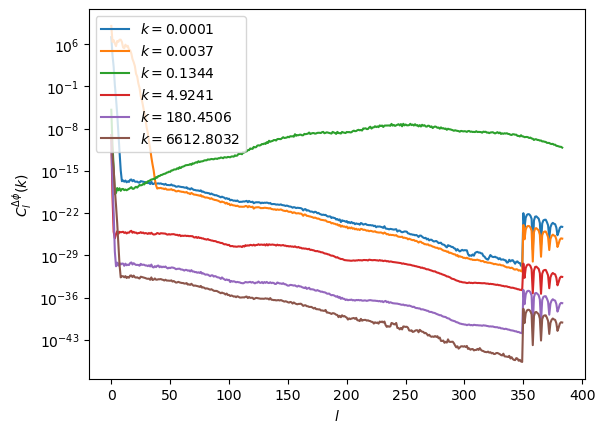

In [405]:
for k_idx, k in zip(np.arange(len(k_array))[::200], k_array[::200]):
    plt.semilogy(Cl_deltap_of_k1_k2[:,k_idx, k_idx], label=r'$k={}$'.format(round(k, 4)))
plt.xlabel(r'$l$')
plt.ylabel(r'$C_l^{\Delta \phi}(k)$')
plt.legend()

There are large oscillations l~350, probably due to the fact that we've had to use Stirling's approximation in FFTLog, but the happen many orders of magnitude below the dominant signal and can probably be ignored. Also, are the bumps at low $l$ physical, or are they numerical artifacts?

(0.001, 10000000.0)

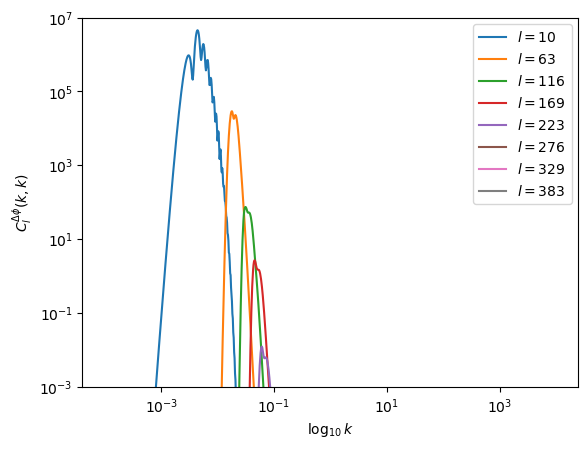

In [406]:
for l_to_plot in np.linspace(10,lmax,8, dtype=int):
    plt.loglog(k_array, np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, k)$')
plt.legend()
plt.ylim([1e-3,1e7])

In [407]:
X, Y = np.meshgrid(np.arange(len(k_array)), np.arange(lmax+1))
Z = np.log10(np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2))

(0.0, 530.0)

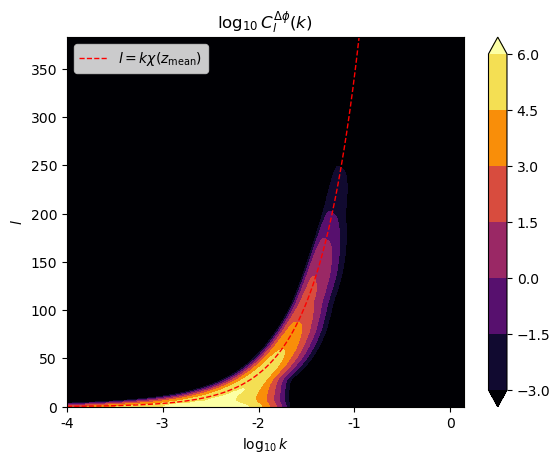

In [446]:
contours = np.arange(-3,7,1.5)

# Smooth array with a Gaussian filter for plotting purposes
Z_smoothed = gaussian_filter(Z, sigma=3)
plt.contourf(X, Y, Z_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', lw=1, label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))
plt.legend()

plt.title(r'$\mathrm{log}_{10} \, C_l^{\Delta \phi}(k)$')
plt.colorbar(location='right')

ax.set_xlim([0,530])

- It's worth investigating the behaviour at low $l$
- How can there be any angular anisotropy at such high $l$ (if suppressed many orders of magnitude relative to the peak signal) if we seeded the perturbations radially on a healpix pixelization characterized by very low nside? 

### Visualizing $C_l^{\Delta \phi}(k_1, k_2)$

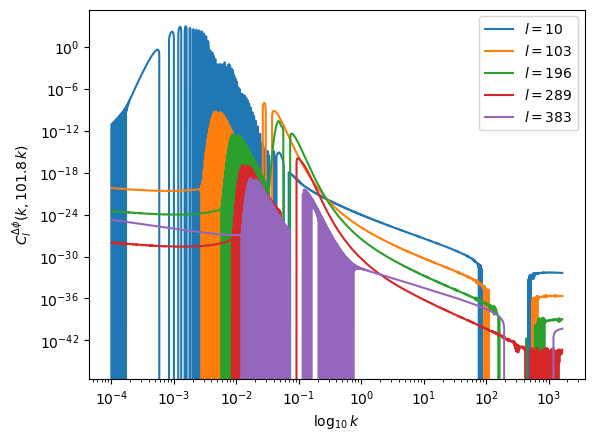

In [409]:
# Let us look into an offset diagonal
offset_idx = 100
offset_k = round((k_array[1]/k_array[0])*offset_idx,1)

for l_to_plot in np.linspace(10,lmax,5, dtype=int):
    plt.loglog(k_array[:-offset_idx], np.diagonal(Cl_deltap_of_k1_k2, axis1=1, axis2=2, offset=offset_idx)[l_to_plot,:], label=r'$l={}$'.format(l_to_plot))
plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$C_l^{\Delta \phi}(k, $'+str(offset_k)+'$\,k)$')

plt.legend()

Wild oscillations ensue once the shift becomes larger than a few tens, so I don't expect any signal to come from regimes with a larger shift

(0.0, 530.0)

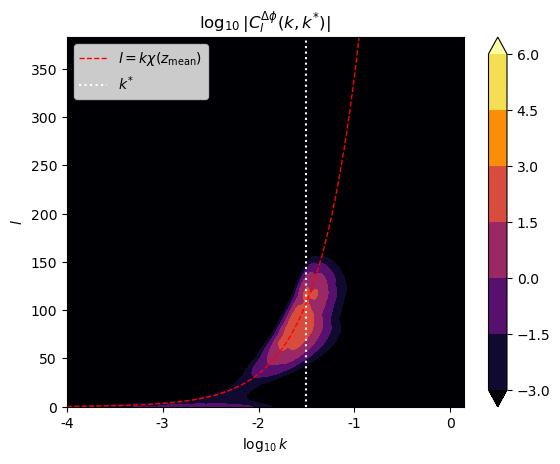

In [445]:
k_idx = np.where(np.log10(k_array)>-1.5)[0][0]

Z_fixed_k = np.log10(np.abs(Cl_deltap_of_k1_k2[:,:,k_idx]))
# Smooth array with a Gaussian filter for plotting purposes
Z_fixed_k_smoothed = gaussian_filter(Z_fixed_k, sigma=3)

plt.contourf(X, Y, Z_fixed_k_smoothed, levels=contours, cmap='inferno', extend='both')

plt.xlabel(r'$\mathrm{log}_{10}\,k$')
plt.ylabel(r'$l$')

ax = plt.gca()
ax.plot(k_array*Planck18.comoving_distance(z_mean).value, color='r', ls='--', lw=1, label=r'$l=k \chi(z_{\mathrm{mean}})$')
ax.set_ylim([0,lmax])

label_locs = np.arange(int(round(np.log10(np.min(k_array)),0)), int(round(np.log10(np.max(k_array)),0))+1, 1)
ax.set_xticks(np.linspace(0, len(k_array), len(label_locs)))
ax.set_xticklabels(label_locs.astype('str'))

plt.title(r'$\mathrm{log}_{10} \, |C_l^{\Delta \phi}(k,k^{*})|$')
plt.colorbar(location='right')

ax.axvline(k_idx, label=r'$k^{*}$', ls=':', color='w')
plt.legend()
ax.set_xlim([0,530])

This suggests that, at a fixed $l$, it might be ok to assume $C_l^{\Delta \phi}(k_1,k_2)\approx \delta^{(D)}(k_1-k_2)C_l^{\Delta \phi}(k_1,k_2)$, especially when $l\gtrapprox50$. NOTE, however, that this might no longer hold if in reality there is some anisotropy to the template, and in fact we don't draw from exactly the same distribution in every pixel.

# Testing FFTLog

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


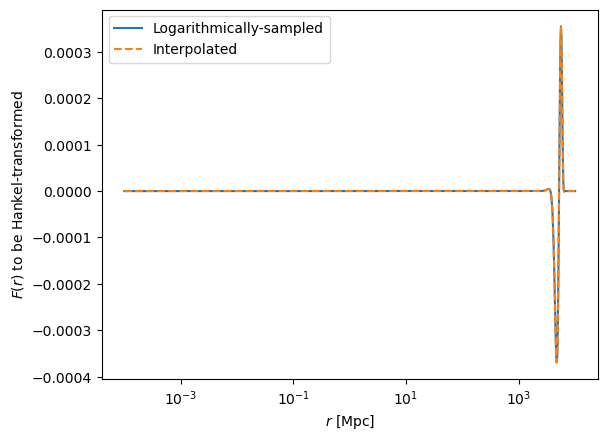

/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.272134e-04
  warnings.warn(
/var/folders/l0/bsqsn6_s01b0hvjnf7bv_wdw0000gn/T/ipykernel_67001/1271661510.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value,
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.727028e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 2.221313e-04
  warnings.warn(
/Users/antonbaleatolizancos/opt/anaconda3/envs/varying_dndz/lib/python3.9/site-packages/scipy/integrate/

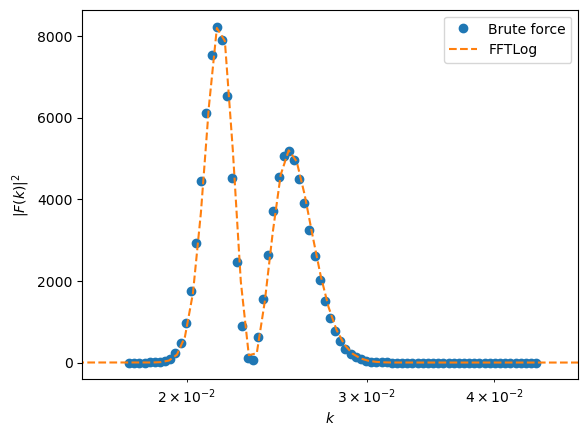

In [15]:
from scipy import interpolate
from scipy.integrate import quadrature
from scipy.special import jv

# Choose just one of the m's that we want to Hankel-transform. We will run our test on this one alone
test_idx = 500
# We will need the l corresponding to this m to compute the (l+0.5)th order Hankel transform
test_l, test_m = hp.Alm.getlm(lmax, test_idx) 

# Interpolate the function to be Hankel transformed so we can do it by brute-force
inter_func = interpolate.interp1d(r_array, theta_alms[test_idx,:], bounds_error=True)
plt.semilogx(r_array, theta_alms[test_idx,:], label='Logarithmically-sampled')
plt.semilogx(r_array, inter_func(r_array), ls='--', label='Interpolated')
plt.xlabel(r'$r$ [Mpc]')
plt.ylabel(r'$F(r)$ to be Hankel-transformed')
plt.legend()
plt.show()

# First, integrate using FFTLog
test_k_array, test_delta_p_lm_of_k = hankl.FFTLog(r_array, r_array*theta_alms[test_idx,:], q=0, 
                                                  mu=test_l+0.5, ext=2, lowring=True)
result_fftlog = test_delta_p_lm_of_k*np.conj(test_delta_p_lm_of_k)/test_k_array**2

# Compare to a brute-force numerical integration
def integrand(r, k, test_l):
    # The integrand of the Hankel transform we want
    return inter_func(r) * r * jv(test_l + 0.5, k*r)

# Use the FFTlog calculation to refine the domain overwhich we do brute force
log_kmin_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][0]])
log_kmax_bruteforce = np.log10(test_k_array[np.where(result_fftlog>0.001)[0][-1]])

shortened_test_k_array = np.logspace(log_kmin_bruteforce, log_kmax_bruteforce, 80)
p_lm_singlek = np.zeros_like(shortened_test_k_array)
err = np.zeros_like(shortened_test_k_array)
for i, test_k in enumerate(shortened_test_k_array):
    # At a few values of k, get the Hankel transform by brute force
    p_lm_singlek[i], err[i] = quadrature(integrand, Planck18.comoving_distance(0.01).value, 
                                   Planck18.comoving_distance(10).value, args=(test_k, test_l),
                                         rtol=0.0000001, maxiter=1000)

plt.semilogx(shortened_test_k_array, p_lm_singlek*np.conj(p_lm_singlek), ls='none', marker='o', label='Brute force')
plt.semilogx(test_k_array, result_fftlog, ls='--', label='FFTLog')
plt.xlabel(r'$k$')
plt.ylabel(r'$|F(k)|^2$')
plt.xlim([10**log_kmin_bruteforce*0.9, 10**log_kmax_bruteforce*1.1])
plt.legend()